## Using the catsim library for adaptive testing

Resources
https://arxiv.org/pdf/1707.03012.pdf


In [4]:
import catsim
from catsim.cat import generate_item_bank
import catsim.initialization
import catsim.selection, catsim.estimation, catsim.stopping, catsim.simulation
import catsim.plot as catplot
from catsim.irt import icc
import matplotlib.pyplot as plt

### Generate dummy items 

Will be generating dummy items and their parameters to serve as question bank

I am using the below snippet to generate items parameters (`a`, `b` and `c`) with certain assumptions
- discrimination: $𝑁(1.2,0.25)$
- difficulty: $𝑁(0,1)$
- pseudo-guessing: $𝑁(0.25,0.02)$

I have kept the correlation between `a` and `b` at `0.2`

In [5]:
bank_size = 5000
corr = 0.2
items = generate_item_bank(n=bank_size, itemtype='3PL', corr=corr)
# catplot.gen3d_dataset_scatter(items)

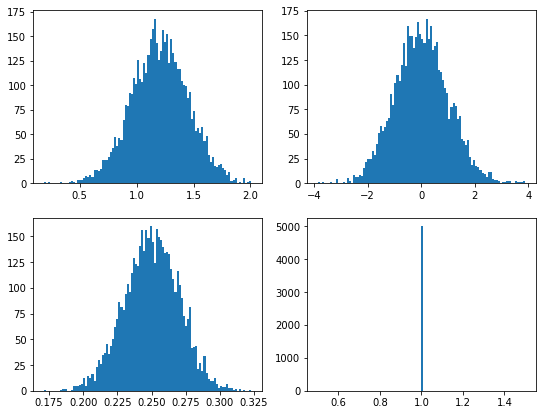

In [6]:
catplot.param_dist(items, figsize=(9, 7))

The top left graph shows distribution of parameters. Top left is `a`, top right is `b`, bottom left-`c` and bottom right is `d`. We use `d` under a 4PL model. It is the upper asymptote parameter of getting an question correct. I have set it to 1, because I think each question is answerable. 

### item characteristic curve

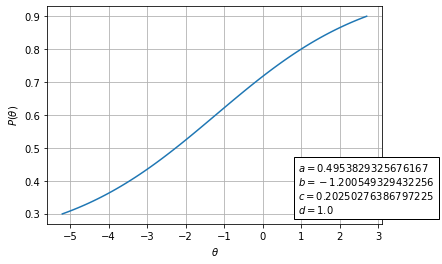

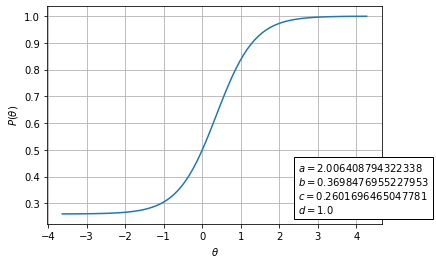

In [7]:
import numpy as np

pos = np.argsort(items[:, 0])[10]
a1, b1, c1, d1 = items[pos]
pos = np.argsort(items[:, 0])[-1]
a2, b2, c2, d2 = items[pos]
catplot.item_curve(a1, b1, c1, d1)
catplot.item_curve(a2, b2, c2, d2)
plt.show()

### Simulating a test

For simulating a test we need a few things ready beforehand

- an item parameter matrix
- a proficiency initializer, which sets the initial 𝜃 values for examinees
- an item selector, which selects items to be applied to examinees according to some rule
- a proficiency estimator, which estimates the new 𝜃 values for examinees after an item is answered
- a stopper, an object which checks if the test must be stopped according to some rule


<p><b>Item parameter matrix: </b>I have already generated an item bank so the first requirement is satisfied. </p>

<p><b>Proficiency initializer: </b>For proficiency, we can randomly initialize. There are other methods too fo example fixed point initializing where we initialize every proficiency at the same point. In random initialization, I'll be selecting proficiencies between -5 to 5.</p>

<p><b>Item selector: </b>Many options to choose from. I will be using `MaxInfoSelector` here</p>
<p><b>Proficiency estimator: </b>Will be using a <a href='https://en.wikipedia.org/wiki/Hill_climbing#:~:text=In%20numerical%20analysis%2C%20hill%20climbing,incremental%20change%20to%20the%20solution.'>hiil climbing estimator</a></p>

<p><b>Test stopping: </b>Two options are available in the package- 
<ul>
    <li>MaxItemStopper: test stops after n items</li>
    <li>MinErrorStopper: based on the minimum standard error of estimation the test must achieve before stopping</li>
</ul>
I have selected MaxItemstopper for here with a cap of 50 items
</p>

<p></p>

In [8]:
# responses = [True, True, False, False]
# administered_items = [1435, 3221, 17, 881]

initializer = catsim.initialization.RandomInitializer(dist_params=(-4, 4))
selector = catsim.selection.MaxInfoSelector()
estimator = catsim.estimation.HillClimbingEstimator()
stopper = catsim.stopping.MaxItemStopper(50)
num_examinees = 10

In the cells below, I have simulated a test with ten examinees. I have assigned each of these ten examiness a true(real) proficiency to begin which we will try to measure in the test. The aim is to get an estimate of a candidate's true proficiency using the test. The test stops when we have administered 50 items. The items generated above will be used to administer the test and the `HillClimbingEstimator` will be used to select the next question.


To begin with, we will randomly assume an examinee's ability, iterate trhough the questions and depending upon his responses, we will update their ability parameter. 

In [9]:
examinees_true_ability = [0.9, 1.6, 2.3, 0.2, -0.4, 0.3, 0.05, -0.007, 0.08, 3.1]
print('num examinees: ', len(examinees_true_ability))

num examinees:  10


In [10]:
s = catsim.simulation.Simulator(items, examinees_true_ability, initializer,
                                selector, estimator, stopper)
s.simulate(verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]


Starting simulation: Random Initializer Maximum Information Selector Hill Climbing Estimator Maximum Item Number Initializer 5000 items


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

Simulation took 5.1586151123046875 seconds


### check model performance

Now that we have administered the test in a controlled setting, we need to see how well our model does. The `Simulator` provides two error metrics -rmse and mse

In [11]:
print('Mean squared error:', s.mse)
print('Root mean squared error:', s.rmse)

Mean squared error: 0.13884383300608805
Root mean squared error: 0.37261754253669815


### evolution of candidate proficiency estimation at every step of the test

Now that we have administered the test, lets look at how our estimate for examinee's proficiency evolved over the test

In [12]:
num_examinees = len(examinees_true_ability)

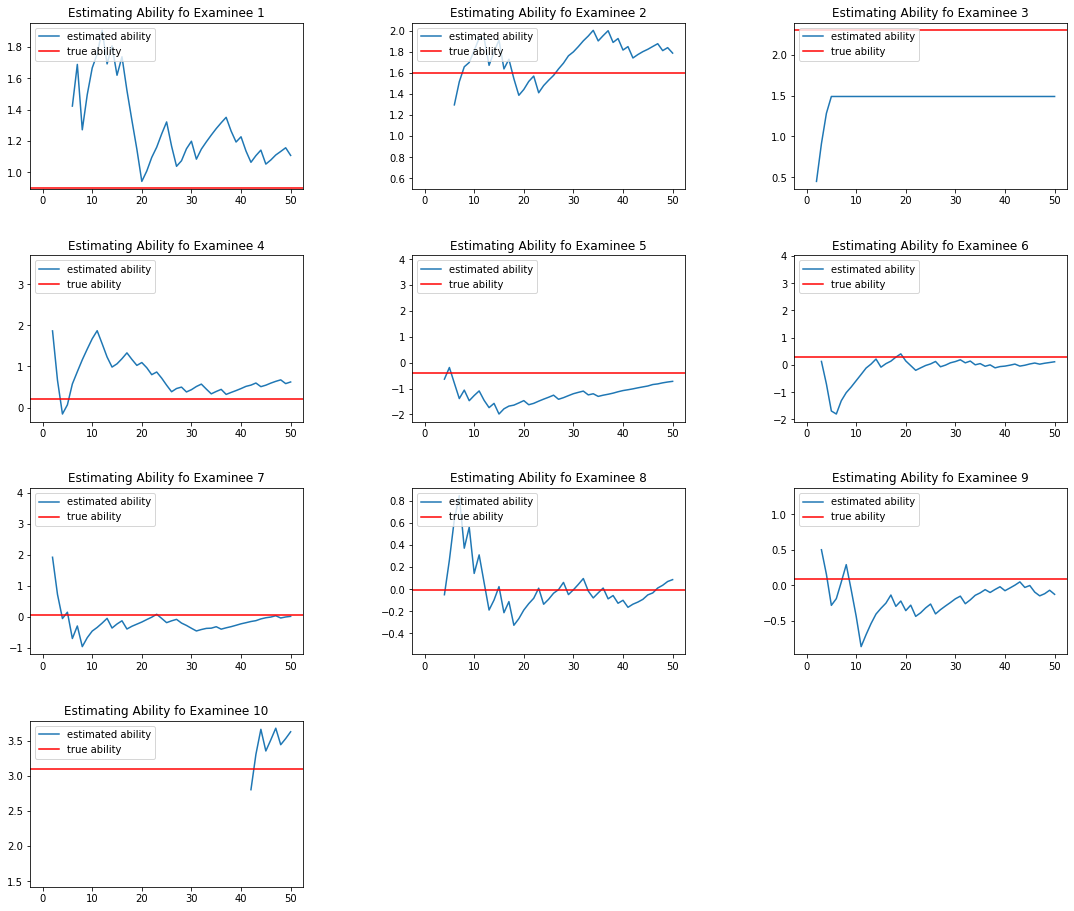

In [13]:
# fig, ax = plt.subplots(nrows=4, ncols=3)
plt.figure(figsize=(18, 15))
for i in range(num_examinees):
    plt.subplot(4, 3, i + 1)
    plt.plot(s.estimations[i], label='estimated ability')
    plt.axhline(y=examinees_true_ability[i],
                color='r',
                linestyle='-',
                label='true ability')
    plt.legend(loc="upper left")
    plt.title('Estimating Ability fo Examinee {}'.format(i + 1))

# plt.fig.tight_layout(pad=3.0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

The blue lines in the above test is how our estimate of a candidate's ability changes with each test item and the red line is the true score that we assigned at the start. The package provides some functionality for plotting as well. An  example

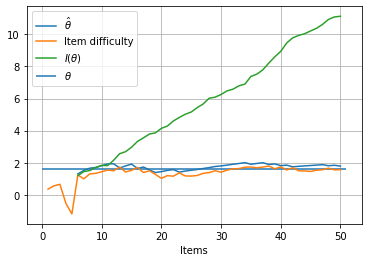

In [14]:
catplot.test_progress(simulator=s, index=1, info=True)

The above plot shows an additional green line which is the information gained at each step of the question

#### Non adaptive Tests

The difference between an adaptive test and a non adaptive test is selection of the next question. To see how a non adaptive test will do we can simply switch our `MaxInfoSelector` item selector with a linear selector

## Using the Catsim module in a real setting

Suppose a candidate is in the middle of a test and has answered a few questions. We now want to administer the next item. Below cells show how that can be done. We will be using the same item bank we generated at the start. 

Also since once we are in the test, we will have some estimate of candidate proficiency. Here I will just assume our esitmate currently is `.393`

In [41]:
ability_est_theta = 0.393

I will further assume that the candidate has answered 5 questions, got the 1st, 3rd and 5th right and 2nd, 4th wrong. We will continue using the same selector and estimator to get the next item and updating our ability estimate

In [62]:
responses = [True, False, True, False, True]
administered_items = [4994, 21, 3, 19, 4989]

initializer = catsim.initialization.RandomInitializer(dist_params=(-4, 4))
selector = catsim.selection.MaxInfoSelector()
estimator = catsim.estimation.HillClimbingEstimator()
stopper = catsim.stopping.MaxItemStopper(50)

### updating ability estimate

In [63]:
new_theta = estimator.estimate(items=items,
                               administered_items=administered_items,
                               response_vector=responses,
                               est_theta=ability_est_theta)
print('Estimated proficiency, given answered items:', new_theta)

Estimated proficiency, given answered items: 0.5327462091416112


### Checking whether the test should end

In [64]:
_stop = stopper.stop(administered_items=items[administered_items],
                     theta=new_theta)
print('Should the test be stopped:', _stop)

Should the test be stopped: False


### selecting new item

In [65]:
item_index = selector.select(items=items,
                             administered_items=administered_items,
                             est_theta=new_theta)
print('Next item to be administered:', item_index)
print('difficulty of item:', items[item_index, 1])

Next item to be administered: 1488
difficulty of item: 0.302716095005142


/usr/local/lib/python3.8/site-packages/catsim/selection.py:86: UserWarning: This selector needs an item matrix with at least 5 columns, with the last one representing item exposure rate. Since this column is absent, it will presume all items have exposure rates = 0
  warn(


### probability that the examinee responds (in)correctly

In [76]:
a, b, c, d = items[item_index]
prob = icc(new_theta, a, b, c, d)
print('P(examinee answers correctly): ', round(prob, 4))

P(examinee answers correctly):  0.681


## Plots

### Item Characteristic Curve and Item Information Curve

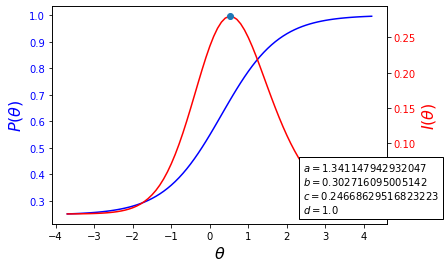

In [79]:
catsim.plot.item_curve(*items[item_index],
                       title=None,
                       ptype='both',
                       max_info=True,
                       show=True)